Let us import all necessary modules:

In [2]:
%pip install sko

  Using cached sko-0.5.7-py3-none-any.whl.metadata (1.9 kB)
Using cached sko-0.5.7-py3-none-any.whl (23 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import csv
import heapq as hp
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import spatial
from sko.GA import GA_TSP
import statistics as stats
import sys

Some of the algorithms allow for a visualization of the intermediate steps. With this variable we can swtich it on or off.

In [34]:
showProgress=True
storePng=False

We initialize a certain number of Monte Carlo rounds.

In [3]:
rounds=10

We use some boolean variable to turn on or off certain algorithms.

In [4]:
runCI=True  # closest insertion algorithm
runFI=False  # farest insertion algorithm (still not implemented)
runGA=True  # genetic algorithm
runNA=False  # nearest addition algorithm (still not implemented)
runNI=False  # nearest insertion algorithm (still not implemented)
runRI=True  # random insertion algorithm (or quick tour)
runPCs=True # pair-center algorithm (slow version)
runPCf=True # pair-center algorithm (somewhat faster version)
runPCq=True # pair-center algorithm (with ideas from quick tour)

The instance file we use as example though out this notebook.

In [5]:
filename='berlin52'

### Some helper function

We take as distance the Euclidean distance between two points. However, you can experiment with other metrics, e.g., the Manhatten distance.

In [6]:
def Distance(p,q):
  #return math.fabs(p[0]-q[0])+math.fabs(p[1]-q[1])
  return math.hypot(p[0]-q[0],p[1]-q[1])

For the total tour length we'll take as distance the rounded Euclidean distance between two points.

In [7]:
def DistanceRounded(p,q):
  return int(math.hypot(p[0]-q[0],p[1]-q[1])+0.5)

A helper function that just computes the side lengths of the triangle built by the three given points.

In [8]:
def TriangleSides(prev,curr,p):
  s0=Distance(prev,curr)
  s1=Distance(prev,p)
  s2=Distance(p,curr)
  return s0,s1,s2

We read a tour in TSPLIB format. Observe that we assume `csv`-files where the separator is the blank, so maybe you need to modify the original files from TSPLIB and remove all spaces in front of a colon etc.

This function tries to read the corresponding optimal tour as well, whenever available in the same directory.

In [9]:
def ReadTsp(fn):
  f=open(fn+".tsp","rt")
  reader=csv.reader(f,delimiter=" ",skipinitialspace=True)
  coordinates=False
  cities=[]
  best=0.0
  index=0
  for row in reader:
    if row[0]=="EOF":
      break
    elif coordinates:
      cities.append((float(row[1]),float(row[2]),index))
      index+=1
    elif row[0]=="BEST:" or row[0]=="OPTIMUM:":
      best=float(row[1])
    elif row[0]=="BEST" or row[0]=="OPTIMUM":
      best=float(row[2])
    elif row[0]=="NAME:":
      print("reading tour",row[1])
    elif row[0]=="NAME":
      print("reading tour",row[2])
    elif row[0]=="NODE_COORD_SECTION":
      coordinates=True
  f.close()
  opt=[]
  try:
    f=open(fn+".opt.tour","rt")
    reader=csv.reader(f,delimiter=" ",skipinitialspace=True)
    coordinates=False
    for row in reader:
      if row[0]=="EOF" or row[0]=="-1":
        break
      elif coordinates:
        index=int(row[0])
        opt.append((cities[index-1][0],cities[index-1][1],index))
      elif row[0]=="NAME:":
        print("reading optimal tour",row[1])
      elif row[0]=="TOUR_SECTION":
        coordinates=True
  except FileNotFoundError:
    print("optimal tour not available")
  finally:
    f.close()

  print("reading done, optimal tour length",best)
  return cities,best,opt

Given a filename and a tour, we write a tour in TSPLIB optimal tour format.

In [10]:
def WriteTsp(fn,T):
  f=open(fn+".opt.tour","wt")
  f.write("NAME: "+fn+".opt.tour\n")
  f.write("COMMENT : Length "+str(TourLength(T))+"\n")
  f.write("COMMENT : Found by tsp [Arno Formella]\n")
  f.write("TYPE: TOUR\n")
  f.write("DIMENSION: "+str(len(T))+"\n")
  f.write("TOUR_SECTION\n")
  for t in T:
    f.write(str(t[2]+1)+"\n")
  f.write("-1\n")
  f.write("EOF\n")
  f.close()
  print("writing done")

We compute the length of a tour by accumulating all distances between neighbors.

In [11]:
def TourLength(T):
  t=len(T)
  if t==0:
    return 0.0
  prev=T[t-1]
  length=0.0
  for i in range(0,t):
    curr=T[i]
    length+=DistanceRounded(prev,curr)
    prev=curr
  return length

As error we use the relative error of the current length compared to the length of the optimal tour in percent.

In [12]:
def TourError(T,best_length):
  return 100.0*(TourLength(T)-best_length)/best_length

We want to plot a tour in a certain color and with/without the connecting segments. Whenever a filename is given, we write a corresponding `.png`-image as output.

In [13]:
def PlotTour(T,col,show=False,onlypoints=False,fn=None,store=True):
  if T!=[]:
    fig,ax=plt.subplots(figsize=(9.6,9.6))
    plt.subplots_adjust(bottom=0.0, left=0.0, right=1.0, top=1.0)
    ax.margins(0.01)
    ax.axis('equal')
    for label in (ax.get_xticklabels()+ax.get_yticklabels()):
      label.set_fontsize(16)

    T.append(T[0])
    x,y,i=zip(*T)
    T.pop(-1)
    if onlypoints==True:
      ax.scatter(
        x,y,s=100,color=col,marker="o",linewidth=3
      )
    else:
      ax.plot(
        x,y,color=col,marker="o",linewidth=3,markeredgewidth=3,markersize=10
      )
    if fn!=None and store:
      plt.savefig(fn,transparent=True,bbox_inches='tight')
    if show:
      plt.show()
    else:
      plt.close(fig)

In order to plot a partial tour (to be able to animate the algorithms) we plot such a tour on top of all cities in a similar way as plotting a complete tour.

In [14]:
def PlotProgressTour(C,T,col,show=False,fn=None,store=True):
  fig,ax=plt.subplots(figsize=(9.6,9.6))
  plt.subplots_adjust(bottom=0.0, left=0.0, right=1.0, top=1.0)
  ax.margins(0.01)
  ax.axis('equal')
  for label in (ax.get_xticklabels()+ax.get_yticklabels()):
    label.set_fontsize(16)

  x,y,i=zip(*C)
  ax.scatter(x,y,s=100,color=col,marker="o",linewidth=3)
  if T!=[]:
    T.append(T[0])
    x,y,i=zip(*T)
    T.pop(-1)
    ax.plot(
      x,y,color="cyan",marker="o",linewidth=1,markeredgewidth=2,markersize=6
    )
  if fn!=None and store:
    plt.savefig(
      fn+"%05d"%(len(T)),transparent=True,bbox_inches='tight'
    )
  if show==True:
    plt.show()
  else:
    plt.close(fig)

We open the file where we will place statistics.

In [15]:
f=open(filename+"_Errors.txt","wt")

In [16]:
def WriteStats(filename,s,f,errors):
  min_error=min(errors)
  avg_error=stats.mean(errors)
  med_error=stats.median(errors)
  if len(errors)>1:
    stdev_error=stats.stdev(errors)
  else:
    stdev_error=0
  max_error=max(errors)
  print("relative error "+
    "{} tour: min {:.2f}% avg {:.2f}% ({:.2f}) med {:.2f}% max {:.2f}%\\\\\n".format(
      s,min_error,avg_error,stdev_error,med_error,max_error
  ))
  f.write(filename+" & "+s+
    " tour & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f}\\\\\n".format(
      min_error,avg_error,stdev_error,med_error,max_error
  ))

### The quick tour (or random insertion) algorithm

  idea:
  - generate a random permutation of the cities
  - take the first three cities to form a triangle to start with
  - proceed with the rest of the points in given random order
    and insert a new city such that the tour increase is minimal
    among all possible insertions
  - stop when there is no more city
  
First we implement the function that returns the index within the given tour T where an insertion of the point p results in a minimum increase of the overall tour length.


In [17]:
def BestInsertionIndex(T,p):
  t=len(T)
  prev=T[t-1]
  curr=T[0]
  s0,s1,s2=TriangleSides(prev,curr,p)
  best_i,shortest=0,s1+s2-s0
  prev=curr
  for i in range(1,t):
    curr=T[i]
    s0,s1,s2=TriangleSides(prev,curr,p)
    increase=s1+s2-s0
    if increase<shortest:
      best_i,shortest=i,increase
    prev=curr
  # print("shortest",shortest,"at",best_i)
  return best_i

Now we implement the overall quick tour (random insertion) algorithm embedded into a Monte Carlo loop with a certain number of rounds and a Las Vegas condition, so we can stop when we found an optimal tour.

We keep and return the best tour that we found during the Monte Carlo loop.

In [18]:
def QuickTour(Cities,rounds,best_length):
  min_error=sys.float_info.max
  errors=[]
  best_tour=[]
  for j in range(0,rounds): # the Monte Carlo loop
    cities=Cities.copy()       # take a new copy of the cities
    random.shuffle(cities)     # mix them up
    tour=[]
    tour.append(cities.pop(0)) # take the first three as starting triangle
    tour.append(cities.pop(0))
    tour.append(cities.pop(0))

    while cities!=[]:  # while there are still unconnected cities
      PlotProgressTour(
        Cities,tour,"skyblue",show=showProgress,fn="progress_QT",
        store=storePng
      )
      c=cities.pop(0)  # take the next city
      i=BestInsertionIndex(tour,c)  # get tour segment with smallest increase
      tour.insert(i,c) # insert city replacing the segment by two new ones
    PlotProgressTour(
      Cities,tour,"skyblue",show=showProgress,fn="progress_QT",
      store=storePng
    )

    error=TourError(tour,best_length)
    errors.append(error)
    print(j+1,"relative error quick tour: ",error,"%")
    if error<min_error:
      min_error=error
      best_tour=tour.copy()
    if error==0.0: # the Las Vegas condition
      print("optimum found in",j,"rounds")
      WriteTsp("bestTour",best_tour)
      break
  return best_tour,errors

Let us run the quick tour algorithm on some example.

In [19]:
if runRI:
  theCities,bestLength,bestTour=ReadTsp(filename)
  if bestLength!=TourLength(bestTour):
    print("strange best tour given",TourLength(bestTour))
  bestT,errors=QuickTour(theCities,rounds,bestLength)
  WriteStats(filename,"quick",f,errors)
  PlotTour(bestT,"skyblue",show=showProgress,fn=filename+"_QuickTour.png")

reading tour berlin52
reading done, optimal tour length 7542.0
1 relative error quick tour:  8.578626359055953 %
2 relative error quick tour:  12.967382657120128 %
3 relative error quick tour:  14.677804295942721 %
4 relative error quick tour:  7.279236276849642 %
5 relative error quick tour:  12.383983028374436 %
6 relative error quick tour:  11.628215327499337 %
7 relative error quick tour:  12.264651286131 %
8 relative error quick tour:  17.422434367541765 %
9 relative error quick tour:  8.180853884911164 %
10 relative error quick tour:  9.798461946433306 %
relative error quick tour: min 7.28% avg 11.52% (3.14) med 11.95% max 17.42%\\



###  The closest-neighbor algorithm

idea:
  - select a random city
  - proceed with connecting the closest still unconnected city
  - stop when there is no more city
  
We implement the algorithm embedded into a Monte Carlo loop with a certain number of rounds and a Las Vegas condition so we can stop when we found an optimal tour.

We keep and return the best tour that we found during the Monte Carlo loop.

In [26]:
def ClosestNeighborTour(Cities,rounds,best_length):
  min_error=sys.float_info.max
  errors=[]
  best_tour=[]
  # because we have random tie break, more rounds than there are points
  # can be advantageous
  for j in range(0,rounds): # the Monte Carlo loop
    cities=Cities.copy()
    random.shuffle(cities)
    tour=[]
    tour.append(cities.pop(0))
    while cities!=[]:
      min_dis=sys.float_info.max
      p=tour[0][0],tour[0][1]
      candidates=[]
      for i in range(0,len(cities)):
        q=cities[i][0],cities[i][1]
        dis=Distance(p,q)
        if dis<min_dis:
          min_dis=dis
          candidates=[]
          candidates.append(i)
        elif dis==min_dis:
          candidates.append(i)
      tour.insert(0,cities.pop(candidates[random.randrange(len(candidates))]))
      PlotProgressTour(
        Cities,tour,"red",show=showProgress,fn="progress_CN",
        store=storePng
      )

    error=TourError(tour,best_length)
    errors.append(error)
    print(j+1,"relative error closest neighbor: ",error,"%")
    if error<min_error:
      min_error=error
      best_tour=tour.copy()
    if error==0.0: # the Las Vegas condition
      print("optimum found in",j,"rounds")
      break
  return best_tour,errors

Let us run the closest neighbor algorithm on some example.

In [27]:
if runCI:
  theCities,bestLength,bestTour=ReadTsp(filename)
  if bestLength!=TourLength(bestTour):
    print("strange best tour given",TourLength(bestTour))

  bestT,errors=ClosestNeighborTour(theCities,rounds,bestLength)
  WriteStats(filename,"closest-neighbor",f,errors)
  PlotTour(bestT,"red",show=showProgress,fn=filename+"_ClosestNeighbor.png")

reading tour berlin52
reading done, optimal tour length 7542.0
1 relative error closest neighbor:  8.47255369928401 %
2 relative error closest neighbor:  29.806417395916203 %
3 relative error closest neighbor:  32.723415539644655 %
4 relative error closest neighbor:  20.96260938743039 %
5 relative error closest neighbor:  22.24874038716521 %
6 relative error closest neighbor:  23.362503314770617 %
7 relative error closest neighbor:  23.760275788915408 %
8 relative error closest neighbor:  17.52850702731371 %
9 relative error closest neighbor:  32.723415539644655 %
10 relative error closest neighbor:  29.806417395916203 %
relative error closest-neighbor tour: min 8.47% avg 24.14% (7.57) med 23.56% max 32.72%\\



### The pair-center algorithm

idea:
  - find closest pair among all pairs of cities
  - substitute this pair of cities by a center city
  - proceed until there is only one city left
  - now we have a binary tree structure
  - travel through the tree top-down and replace
    a "center" by its underlying pair taking care of inserting
    the best possibility
  - stop when all pairs are handled
  
The algorithm uses a data structure of a dictionary to hold the binary tree. Each entry in the dictionary uses as key the index of the current point (either an orignal city or a center being constructed during the progress of the algorithm) and as information a tuple that holds both indices of the points being paired and the coordinates. Hence the tuple `(i,j,x,y)` is the center of points with index `i` and index `j` at location `(x,y)`.

 We need a function that returns a pair of indices with minimal distance among all possible distances witin the point set L.
 If there is more than one such pair, a random one of those is returned.

In [28]:
def ClosestPair(L):
  t=len(L)
  best=sys.float_info.max
  pairs=[]
  for i in range(0,t):
    for j in range(i+1,t):
      s0=Distance(L[i],L[j])
      if s0<best:
        best=s0
        pairs=[]
        pairs.append((i,j))
      elif s0==best:
        pairs.append((i,j))
  return pairs[random.randrange(len(pairs))]

Given a list of indices (keys) into a dictionary we build the corresponding tour.

In [29]:
def MakeTourWithDictionary(I,D):
  T=[]
  for i in I:
    T.append((D[i][2],D[i][3],i))
  return T

Now we implement the overall pair-center tour algorithm which is a deterministic heuristic algorithm.
This version is still not very good, it could be improved by handling the closest pairs in a more sophisticated data structure, so the overall runtime can be brought down from cubic to something more efficient. 

In [30]:
def PairCenterTour(Cities,best_length):
  cities=Cities.copy()
  mark=0
  D={}
  for p in Cities:
    D[mark]=(-1,-1,p[0],p[1])
    mark+=1

  # First build the binary tree inserting the corresponding centers
  while len(cities)>1:
    a,b=ClosestPair(cities);
    x,y=0.5*(cities[a][0]+cities[b][0]),0.5*(cities[a][1]+cities[b][1])
    D[mark]=(cities[a][2],cities[b][2],x,y)
    cities[a]=(x,y,mark)
    mark+=1
    cities.pop(b)

  # Run the tree downwards and insert the corresponding pair in
  # the best possible way
  mark-=1
  L=[]
  L.append(D[mark][0])
  PlotProgressTour(
    Cities,MakeTourWithDictionary(L,D),"blue",show=showProgress,
    fn="progress_PC",store=storePng
  )
  L.append(D[mark][1])
  PlotProgressTour(
    Cities,MakeTourWithDictionary(L,D),"blue",show=showProgress,
    fn="progress_PC",store=storePng
  )
  t=len(Cities)
  for m in range(mark-1,t-1,-1):
    i=L.index(m)
    Di0=D[L[i]][0]
    Di1=D[L[i]][1]
    q=(D[Di0][2],D[Di0][3])
    r=(D[Di1][2],D[Di1][3])
    p=s=(0,0)
    if i==len(L)-1:
      p=(D[L[i-1]][2],D[L[i-1]][3])
      s=(D[L[0]][2],D[L[0]][3])
    elif i==0:
      p=(D[L[len(L)-1]][2],D[L[len(L)-1]][3])
      s=(D[L[1]][2],D[L[1]][3])
    else:
      p=(D[L[i-1]][2],D[L[i-1]][3])
      s=(D[L[i+1]][2],D[L[i+1]][3])

    if Distance(p,q)+Distance(r,s)>Distance(p,r)+Distance(q,s):
      L[i]=D[m][1]
      L.insert(i+1,D[m][0])
    else:
      L[i]=D[m][0]
      L.insert(i+1,D[m][1])
    PlotProgressTour(
      Cities,MakeTourWithDictionary(L,D),"blue",show=showProgress,
      fn="progress_PC",store=storePng
    )

  tour=MakeTourWithDictionary(L,D)
  error=TourError(tour,best_length)
  errors=[]
  errors.append(error)
  return tour,errors

Let's run the pair-center algorithm on some example:

In [31]:
if runPCs:
  theCities,bestLength,bestTour=ReadTsp(filename)
  if bestLength!=TourLength(bestTour):
    print("strange best tour given",TourLength(bestTour))

  bestT,errors=PairCenterTour(theCities,bestLength)
  WriteStats(filename,"pair-center (slow)",f,errors)
  PlotTour(bestT,"blue",show=showProgress,fn=filename+"_PairCenterSlow.png")

reading tour berlin52
reading done, optimal tour length 7542.0
relative error pair-center (slow) tour: min 7.27% avg 7.27% (0.00) med 7.27% max 7.27%\\



### A somewhat faster pair-center algorithm

idea:
  - find closest pair among all pairs of cities with a spatial data structure (kd-tree) and neighbor lists
  - substitute this pair of cities by a center city
  - proceed until there is only one city left
  - now we have a binary tree structure
  - travel through the tree top-down and replace
    a "center" by its underlying pair taking care of inserting
    the best possibility
  - stop when all pairs are handled
  
The algorithm uses a data structure of a dictionary to hold the binary tree. Each entry in the dictionary uses as key the index of the current point (either an orignal city or a center being constructed during the progress of the algorithm) and as information a tuple that holds both indices of the points being paired and the coordinates. Hence the tuple `(i,j,x,y)` is the center of points with index `i` and index `j` at location `(x,y)`.

In [32]:
# We calculate the interpoint distances with a spatial data structure.
def LowerBoundFast(C,pq,N):
  kD=spatial.KDTree([(c[0],c[1]) for c in C])
  lower=0.0
  for c in C:
    nn=kD.query((c[0],c[1]),k=2)
    min_dis=int(nn[0][1]+0.5)
    min_j=nn[1][1]
    hp.heappush(pq,(min_dis,c[2],min_j))
    N[min_j].append(c[2])
    lower+=min_dis
  return lower

Some more helper function for a faster pair-center algorithm.

In [33]:
def MakeTourWithTree(tree):
  T=[]
  i=0
  for t in tree:
    if t[4]:
      T.append((t[2],t[3],i))
      i+=1
  return T

def MakeTourWithList(L,tree):
  T=[]
  i=0
  for l in L:
    T.append((tree[l][2],tree[l][3],i))
    i+=1
  return T

def HandleNeighbors(tree,N,pq,l,x,y):
  min_dis=sys.float_info.max
  min_j=-1
  for j in range(len(tree)-1):
    if l!=j and tree[j][4]:
      dis=Distance((tree[j][2],tree[j][3]),(x,y))
      if dis<min_dis:
        min_dis=dis
        min_j=j
  if min_j!=-1:
    hp.heappush(pq,(min_dis,l,min_j))
    N[min_j].append(l)

Now we implement the overall faster pair-center tour algorithm which is also a deterministic heuristic algorithm.
This version is somewhat faster, it still could be improved easily regarding the tour length.

In [34]:
def PairCenterTourFast(Cities,best_length,pq,N):
  tree=[(-1,-1,p[0],p[1],True) for p in Cities]

  # First build the binary tree inserting the corresponding centers
  n=len(tree)
  r=0
  while r<n-1:
    d,a,b=hp.heappop(pq)
    if tree[a][4] and tree[b][4]:
      x,y=0.5*(tree[a][2]+tree[b][2]),0.5*(tree[a][3]+tree[b][3])
      tree.append((a,b,x,y,True))
      tree[a]=(tree[a][0],tree[a][1],tree[a][2],tree[a][3],False)
      tree[b]=(tree[b][0],tree[b][1],tree[b][2],tree[b][3],False)
      HandleNeighbors(tree,N,pq,n+r,x,y)
      for l in N[a]:
        if tree[l][4]:
          x,y=tree[l][2],tree[l][3]
          HandleNeighbors(tree,N,pq,l,x,y)
      for l in N[b]:
        if tree[l][4]:
          x,y=tree[l][2],tree[l][3]
          HandleNeighbors(tree,N,pq,l,x,y)
      r+=1
  assert len(tree)==2*n-1

  # Run the tree downwards and insert the corresponding pair in
  # the best possible way
  L=[]
  a=tree[-1][0]
  b=tree[-1][1]
  L.append(a)
  L.append(b)
  PlotProgressTour(
    Cities,MakeTourWithTree(tree),"blue",show=showProgress,
    fn="progress_PF",store=storePng
  )
  t=len(tree)-2
  for m in range(t,n-1,-1):
    i0,i1=tree[m][0],tree[m][1]
    q=(tree[i0][2],tree[i0][3])
    r=(tree[i1][2],tree[i1][3])
    i=L.index(m)
    if i==len(L)-1:
      p=(tree[L[i-1]][2],tree[L[i-1]][3])
      s=(tree[L[0]][2],tree[L[0]][3])
    elif i==0:
      p=(tree[L[len(L)-1]][2],tree[L[len(L)-1]][3])
      s=(tree[L[1]][2],tree[L[1]][3])
    else:
      p=(tree[L[i-1]][2],tree[L[i-1]][3])
      s=(tree[L[i+1]][2],tree[L[i+1]][3])

    if Distance(p,q)+Distance(r,s)>Distance(p,r)+Distance(q,s):
      a,b=tree[m][1],tree[m][0]
    else:
      a,b=tree[m][0],tree[m][1]
    L[i]=a
    L.insert(i+1,b)
    PlotProgressTour(
      Cities,MakeTourWithList(L,tree),"blue",show=showProgress,
      fn="progress_PF",store=storePng
    )
  tour=MakeTourWithList(L,tree)
  error=TourError(tour,best_length)
  errors=[]
  errors.append(error)
  return tour,errors

Run the faster pair-center algorithm.

In [35]:
if runPCf:
  pq=[]
  N=[[] for i in range(2*len(theCities))]
  lowerBound=LowerBoundFast(theCities,pq,N)
  print("lower bound",lowerBound)
  bestT,errors=PairCenterTourFast(theCities,bestLength,pq.copy(),N.copy())
  WriteStats(filename,"pair-center (fast)",f,errors)
  PlotTour(bestT,"blue",show=showProgress,fn=filename+"_PairCenterFast.png")

lower bound 5298.0
relative error pair-center (fast) tour: min 7.27% avg 7.27% (0.00) med 7.27% max 7.27%\\



Now we implement the overall faster and better pair-center tour algorithm which is still a deterministic heuristic algorithm.
This version is somewhat better, it still could be improved easily regarding the tour length.

We use the quick tour idea to improve the basic pair-center algorithm.

In [36]:
def PairCenterTourQuick(Cities,best_length,pq,N):
  tree=[(-1,-1,p[0],p[1],True) for p in Cities]
  n=len(tree)
  r=0
  while r<n-1:
    d,a,b=hp.heappop(pq)
    if tree[a][4] and tree[b][4]:
      x,y=0.5*(tree[a][2]+tree[b][2]),0.5*(tree[a][3]+tree[b][3])
      tree.append((a,b,x,y,True))
      tree[a]=(tree[a][0],tree[a][1],tree[a][2],tree[a][3],False)
      tree[b]=(tree[b][0],tree[b][1],tree[b][2],tree[b][3],False)
      HandleNeighbors(tree,N,pq,n+r,x,y)
      for l in N[a]:
        if tree[l][4]:
          x,y=tree[l][2],tree[l][3]
          HandleNeighbors(tree,N,pq,l,x,y)
      for l in N[b]:
        if tree[l][4]:
          x,y=tree[l][2],tree[l][3]
          HandleNeighbors(tree,N,pq,l,x,y)
      r+=1
  assert len(tree)==2*n-1

  # Run the tree downwards and insert the corresponding pair in
  # the best possible way
  L=[]
  tour=[]
  a=tree[-1][0]
  b=tree[-1][1]
  L.append(a)
  L.append(b)
  t=0
  tour.append((tree[a][2],tree[a][3],t)); t+=1
  tour.append((tree[b][2],tree[b][3],t)); t+=1
  PlotProgressTour(
    Cities,tour,"blue",show=showProgress,fn="progress_QP",store=storePng
  )
  t=len(tree)-2
  pro=0
  for m in range(t,n-1,-1):
    pro+=1
    if pro%500==0:
      print(pro,"QP second done")
    i0,i1=tree[m][0],tree[m][1]
    i=L.index(m)

    tour[i]=(tree[i0][2],tree[i0][3],tour[i][2])
    c=(tree[i1][2],tree[i1][3],t); t+=1
    j=BestInsertionIndex(tour,c)
    tour.insert(j,c)
    L[i]=tree[m][0]
    L.insert(j,tree[m][1])
    PlotProgressTour(
      Cities,tour,"blue",show=showProgress,fn="progress_QP",store=storePng
    )
  error=TourError(tour,best_length)
  errors=[]
  errors.append(error)
  return tour,errors

Run the improved pair-center algorithm.

In [37]:
if runPCq:
  bestT,errors=PairCenterTourQuick(theCities,bestLength,pq,N)
  WriteStats(filename,"pair-center (quick)",f,errors)
  PlotTour(bestT,"blue",
    show=showProgress,fn=filename+"_PairCenterQuick.png"
  )

relative error pair-center (quick) tour: min 1.74% avg 1.74% (0.00) med 1.74% max 1.74%\\



For a more sophisticated and much faster implemention of the pair-center algorithm take a look into the publication.

### The genetic algorithm tour

Given a list of indices into the list of location, we build the corresponding tour.

In [17]:
def MakeTourWithCities(I,C):
  return [(C[i][0],C[i][1],i) for i in I]

We implement the computation of a tour with the genetic algorithm from the `scikit-opt` package.

In [39]:
# Compare variation of stochastic heuristic with GAs
# Compare averages and best performances
# Compare execution times (higher for GA)

from sko.operators.selection import selection_tournament_faster
def GeneticAlgorithmTour(cities,best_length,config, repetitions):
  n=len(cities)
  points_coordinate=[(l[0],l[1]) for l in cities]

  dist_mat=spatial.distance.cdist(
    points_coordinate, points_coordinate, metric='euclidean'
  )

  def cal_total_distance(routine):
      '''The objective function. input routine, return total distance.
      cal_total_distance(np.arange(n))
      '''
      n,=routine.shape
      return sum([dist_mat[routine[i%n], routine[(i+1)%n]] for i in range(n)])

  errors=[]
  best_error = np.inf
  best_T = None

  for r in range(repetitions):
      ga_tsp=GA_TSP(
        func=cal_total_distance, n_dim=n, size_pop=config['pop_size'], max_iter=config['generations'], prob_mut=config['mut_prob']
      )
        
      # by overriding the selection function of the algorithm it is possible to set different tournament sizes
      def select_f():
        return selection_tournament_faster(ga_tsp, config['tourn_size'])
      ga_tsp.selection = select_f
    
      best_points, best_distance=ga_tsp.run()
      T=MakeTourWithCities(best_points,theCities)
      error=TourError(T,bestLength)
      errors.append(error)
      if error < best_error:
          best_T = T
      
  return best_T, errors

In [ ]:
ranges = {
    'generations': [100, 50],
    'pop_size': [200, 100],
    'mut_prob': [0.2, 0.1],
    'tourn_size': [10, 3]
}

# default value is the one in the middle of the array of different parameter values to test
def getDefault(values):
    return values[int(floor(len(values)/2))]

# iterate all value ranges picking the value in the middle
getDefaultConfig = lambda value_ranges: {k: getDefault(values) for k, values in value_ranges.items()}

def sweepParameterValues(param_name, problem):
    config = getDefaultConfig(value_ranges)

    value_range = value_ranges[param_name]
    default_value = getDefault(value_range)
    vals = []

    # evaluate different values that are not the default one
    for value in value_range:
        # a simulation with all default values is run separately and once
        if value == default_value:
            continue

        config[param_name] = value
        metrics = evaluateConfig(param_name + " = " + str(value), config, problem)
        vals.append(metrics)

    return vals

def fullEval(problem, table1, table2):
    default_config = getDefaultConfig(value_ranges)
    dBest, dAvg, dStd = evaluateConfig("Default configuration", default_config, problem)

    for param_name in value_ranges.keys():
        # skip sweep of precision when using real coding
        if param_name == 'precision' and not problem['bin_coding']:
            continue

        vals = sweepParameterValues(param_name, problem)
        (lBest, lAvg, lStd), (hBest, hAvg, hStd) = vals[0], vals[1]
        latexName = param_name.replace('_', '\\_')

        table1 += f"""{latexName} & {lBest:.2E} & {dBest:.2E} & {hBest:.2E} \\\\
    \\hline\n"""
        table2 += f"""{latexName} & {lAvg:.2E}±{lStd:.2E} & {dAvg:.2E}±{dStd:.2E} & {hAvg:.2E}±{hStd:.2E} \\\\
    \\hline\n"""

    tabEnd = "\\end{tabular}\\end{center}"
    table1 += tabEnd; table2 += tabEnd

    return table1, table2

tableHeader1 = """\\begin{center}
\\begin{tabular}{ |p{1.5cm}|c|c|c| }
 \\hline
 & \\multicolumn{3}{|c|}{Best error}\\\\
  \\hline
 Value & Lower & Default & Higher \\\\
  \\hline\n"""

tableHeader2 = """\\begin{center}
\\begin{tabular}{ |p{1.5cm}|c|c|c| }
 \\hline
 & \\multicolumn{3}{|c|}{Average lowest error}\\\\
  \\hline
 Value & Lower & Default & Higher \\\\
  \\hline\n"""

for prob in problems:
    if not os.path.exists(prob['name'] + '_' + img_path):
        os.makedirs(prob['name'] + '_' + img_path)
    table1, table2 = fullEval(prob, tableHeader1, tableHeader2)
    print(f"Tables for problem {prob['name']}:")
    print(table1)
    print(table2)



reading tour berlin52
reading done, optimal tour length 7542.0
relative error genetic algorithm tour: min 74.58% avg 88.51% (8.35) med 88.28% max 103.29%\\



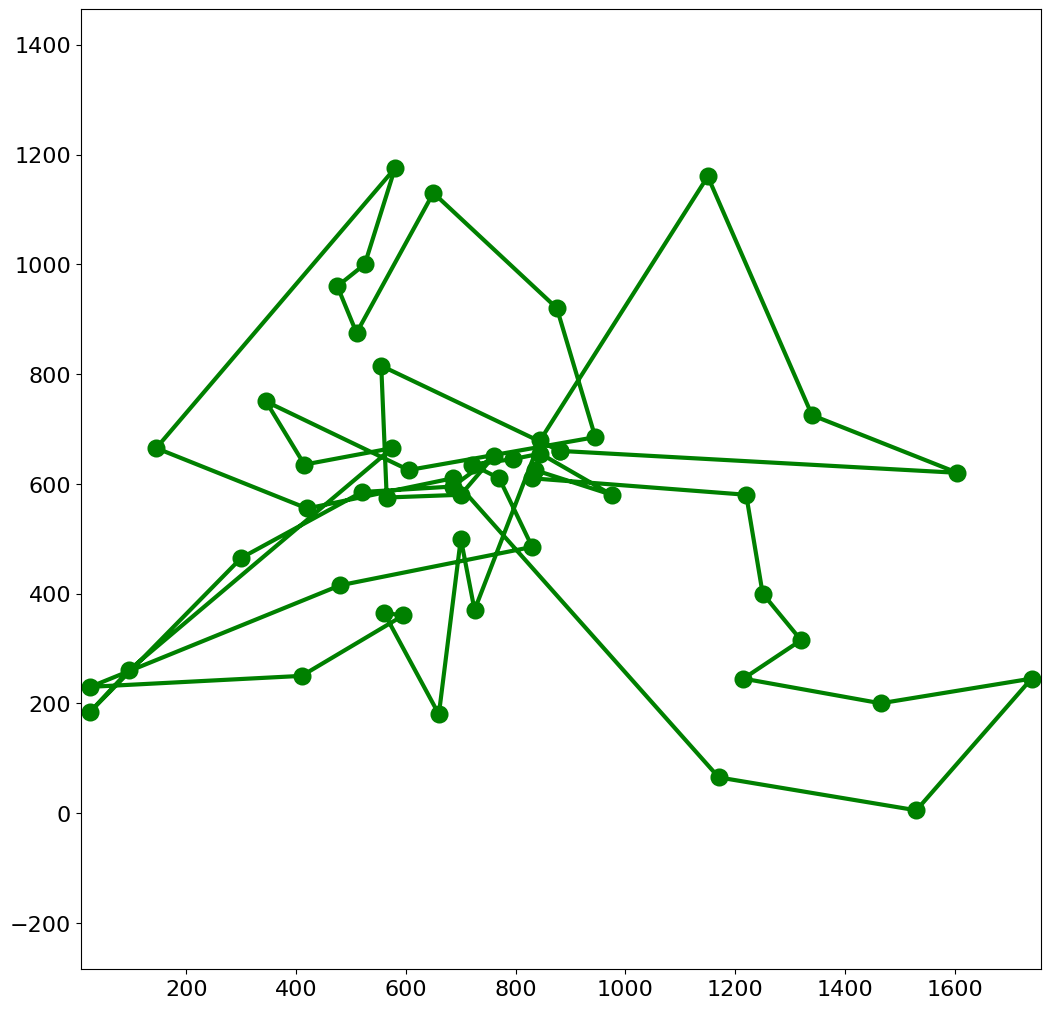

In [42]:
if runGA:
  theCities,bestLength,bestTour=ReadTsp(filename)
  if bestLength!=TourLength(bestTour):
    print("strange best tour given",TourLength(bestTour))

  bestT, errors = GeneticAlgorithmTour(theCities, bestLength, config, 30)
  WriteStats(filename, "genetic algorithm", f, errors)
  PlotTour(bestT, "green", show=showProgress, fn=filename + "_GeneticAlgorithm.png")

We calculate the complete matrix of interpoint distances and compute the simple lower bound for the length of a tour. We plot both: the cities and the best tour from the input file.

In [32]:
def LowerBound(M,n):
  if len(M)!=n*n:
    print("usage error in LowerBound")
    exit()
  lower=0.0
  for i in range(0,n):
    min_index=sys.float_info.max
    for j in range(0,n):
      if i!=j:
        curr=M[i*nloc+j]
        if curr<min_index:
          min_index=curr
    lower+=min_index
  return lower

Some lower bound computation.

reading tour berlin52
reading done, optimal tour length 7542.0
lower bound 5298.0


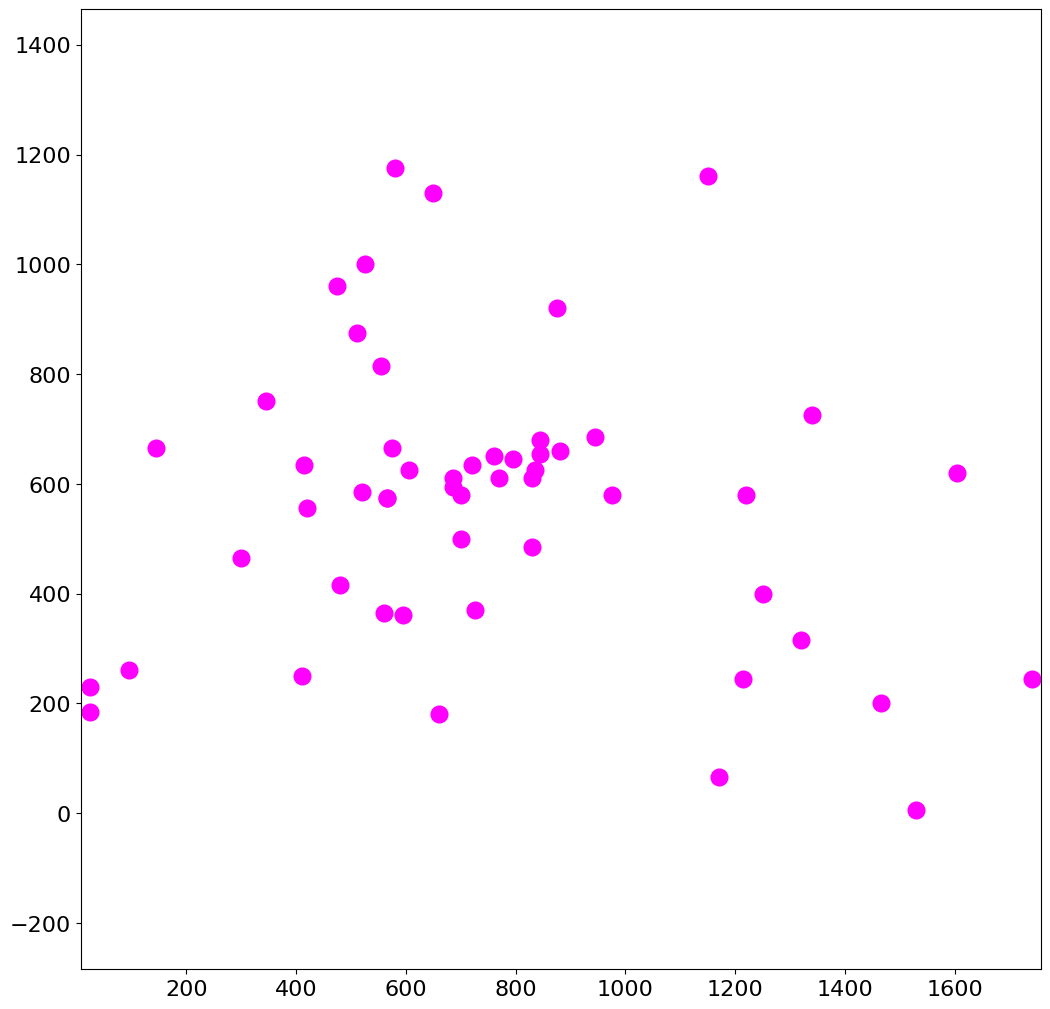

best tour length 7542.0


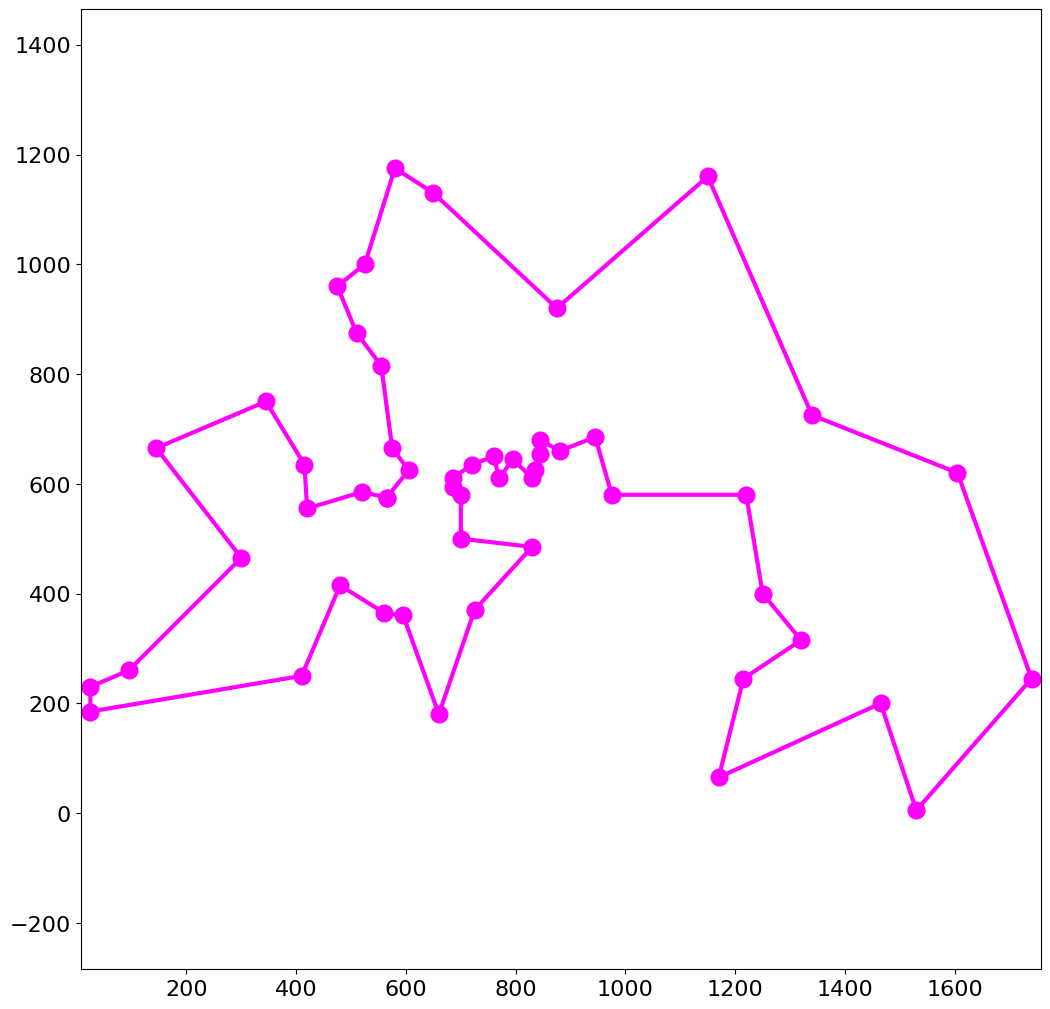

In [36]:
theCities,bestLength,bestTour=ReadTsp(filename)
if bestLength!=TourLength(bestTour):
  print("strange best tour given",TourLength(bestTour))

nloc=len(theCities)
Dmat=[
  DistanceRounded((theCities[i][0],theCities[i][1]),(theCities[j][0],theCities[j][1]))
    for i in range(0,nloc) for j in range(0,nloc)
  ]
print("lower bound",LowerBound(Dmat,nloc))
PlotTour(theCities,"magenta",show=showProgress,onlypoints=True,fn=filename+"_Cities.png")

# show best tour
print("best tour length",bestLength)
PlotTour(bestTour,"magenta",show=showProgress,fn=filename+"_BestTour")